In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import approx_fprime
import scipy.ndimage


In [2]:
#1) Define two random sampling until they present different signals - OK
#2) Walk from one to the other using a half distance - OK
#3) Define a tolerance away from absolute zero - OK
#4) Calculate the raw error gradient - 
#5) Decide the next steps
#6) Use one gradient to guarantee it stays close to zero and the other to guide to the actual zero

In [3]:
# 1. Linear Model
def linear_model(x, a, b):
    x = np.array(x)
    return a * np.sum(x) + b

# 2. Sphere Model (Quadratic)
def sphere_model(x, a, b):
    x = np.array(x)
    return a * np.sum(np.square(x)) + b

# 3. Rosenbrock Model (Shifted Quadratic)
def rosenbrock_model(x, a, b):
    x = np.array(x)
    if len(x) == 2:
        return a * np.sum(100 * (x[1:] - x[:-1]**2)**2 + (x[:-1] - 1)**2) + b
    else:
        return a * np.sum(100 * (x - x**2)**2 + (x - 1)**2) + b

# 4. Ackley Model (Exponential)
def ackley_model(x, a, b):
    x = np.array(x)
    d = len(x)
    return a * (-20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / d)) - np.exp(np.sum(np.cos(2 * np.pi * x)) / d) + 20 + np.e) + b

# 5. Rastrigin Model (Quadratic + Cosine)
def rastrigin_model(x, a, b):
    x = np.array(x)
    d = len(x)
    return a * (10 * d + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))) + b

# 6. Levy Model (Sinusoidal)
def levy_model(x, a, b):
    x = np.array(x)
    w = 1 + (x - 1) / 4
    term1 = np.sin(np.pi * w[0])**2
    term2 = np.sum((w[:-1] - 1)**2 * (1 + 10 * np.sin(np.pi * w[:-1] + 1)**2))
    term3 = (w[-1] - 1)**2 * (1 + np.sin(2 * np.pi * w[-1])**2)
    return a * (term1 + term2 + term3) + b

def rastrigin_levy_model(x, a, b):
    x = np.array(x)
    d = len(x)
    rastrigin = a * (10 * d + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))) + b - a**2
    w = 1 + (x - 1) / 4
    levy = a * (np.sin(np.pi * w[0])**2 + (w[-1] - 1)**2 * (1 + np.sin(2 * np.pi * w[-1])**2)) + b * a
    return rastrigin - levy  # Subtracting introduces non-trivial behavior

# 2. Combination of Rosenbrock and Ackley (Valley & Oscillations)
def rosenbrock_ackley_model(x, a, b):
    x = np.array(x)
    d = len(x)
    rosenbrock = a * np.sum(100 * (x - x**2)**2 + a * (x - 1)**2) + b
    ackley = a * (-20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / d)) - np.exp(np.sum(np.cos(2 * np.pi * x)) / d) + 20 + np.e) + b
    return rosenbrock + ackley  # Adding them creates complex curvatures

# 3. Combination of Sphere and Sinusoidal Perturbations (Simple + Wave Distortions)
def sphere_sinusoidal_model(x, a, b):
    x = np.array(x)
    sphere = a * np.sum(np.square(x)) + b
    sinusoidal = a * np.sin(5 * np.pi * x) * np.cos(3 * np.pi * x)
    return sphere + sinusoidal  # Sinusoidal perturbation adds roughness

In [4]:
# 1. Linear Model
def linear_model_b(x, a, b):
    x = np.array(x)
    return a * np.sum(x) + b * a

# 2. Sphere Model (Quadratic)
def sphere_model_b(x, a, b):
    x = np.array(x)
    return a * np.sum(np.square(x)) + b

# 3. Rosenbrock Model (Shifted Quadratic)
def rosenbrock_model_b(x, a, b):
    x = np.array(x)
    if len(x) == 2:
        return a * np.sum(100 * (x[1:] - x[:-1]**2)**2 + b*(x[:-1] - 1)**2) + b
    else:
        return a * np.sum(100 * (x - x**2)**2 + b * (x - 1)**2) + b

# 4. Ackley Model (Exponential)
def ackley_model_b(x, a, b):
    x = np.array(x)
    d = len(x)
    return a * (-20 * a * 2 + b**2 + np.exp(-0.2 * np.sqrt(np.sum(x**2) / d)) - np.exp(np.sum(np.cos(2 * np.pi * x)) / d) + 20 + np.e) + b

# 5. Rastrigin Model (Quadratic + Cosine)
def rastrigin_model_b(x, a, b):
    x = np.array(x)
    d = len(x)
    return a * (10 * d + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))) + b - a**2

# 6. Levy Model (Sinusoidal)
def levy_model_b(x, a, b):
    x = np.array(x)
    w = 1 + (x - 1) / 4
    term1 = np.sin(np.pi * w[0])**2
    term2 = np.sum((w[:-1] - 1)**2 * (1 + 10 * np.sin(np.pi * w[:-1] + 1)**2))
    term3 = (w[-1] - 1)**2 * (1 + np.sin(2 * np.pi * w[-1])**2)
    return a * (term1 + term2 + term3) + b * a

def rastrigin_levy_model(x, a, b):
    x = np.array(x)
    d = len(x)
    rastrigin = a * (10 * d + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))) + b - a**2
    w = 1 + (x - 1) / 4
    levy = a * (np.sin(np.pi * w[0])**2 + (w[-1] - 1)**2 * (1 + np.sin(2 * np.pi * w[-1])**2)) + b * a
    return rastrigin - levy  # Subtracting introduces non-trivial behavior

# 2. Combination of Rosenbrock and Ackley (Valley & Oscillations)
def rosenbrock_ackley_model(x, a, b):
    x = np.array(x)
    d = len(x)
    rosenbrock = a * np.sum(100 * (x - x**2)**2 + a * (x - 1)**2) + b
    ackley = a * (-20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / d)) - np.exp(np.sum(np.cos(2 * np.pi * x)) / d) + 20 + np.e) + b
    return rosenbrock + ackley  # Adding them creates complex curvatures

# 3. Combination of Sphere and Sinusoidal Perturbations (Simple + Wave Distortions)
def sphere_sinusoidal_model(x, a, b):
    x = np.array(x)
    sphere = a * np.sum(np.square(x)) + b
    sinusoidal = a * np.sin(5 * np.pi * x) * np.cos(3 * np.pi * x)
    return sphere + sinusoidal  # Sinusoidal perturbation adds roughness

# The correct for a loss is with np.array(x), but I guess the "constant depending on x" is also ok

In [5]:
def model_1(x, a, b):
    x = np.array(x)
    return a**2 + b * np.sum(x)

def model_2(x, a, b):
    x = np.array(x)
    return a * np.sum(x) + a**2 + b + b**2

def model_3(x, a, b):
    x = np.array(x)
    return a * np.sum(x) + b

def model_4(x, a, b):
    x = np.array(x)
    return a + b**3 * np.sum(x)

def model_5(x, a, b):
    x = np.array(x)
    return a*3 + b * np.sum(x)

def model_6(x, a, b):
    x = np.array(x)
    return a**2 * b**3 +  a*3 * b**5

def model_7(x, a, b):
    x = np.array(x)
    return a * b + a**2 + b

def model_8(x, a, b):
    x = np.array(x)
    return a * b + a**2 + b + b**3

def model_9(x, a, b):
    x = np.array(x)
    return a + a**2 + b

In [6]:
def model_1(x, a, b):
    return np.sin(a * b) + np.cos(a + b)

def model_2(x, a, b):
    return a * np.sin(b**2) + b * np.cos(a**2)

def model_3(x, a, b):
    return np.exp(-a**2 - b**2) * np.sin(5 * a) * np.cos(5 * b)

def model_4(x, a, b):
    return np.log1p(np.abs(a * b)) + np.sin(a**2 + b**2)

def model_5(x, a, b):
    return (a**2 - b**2) * np.sin(2 * a) * np.cos(2 * b)

def model_6(x, a, b):
    return np.abs(np.sin(a) + np.cos(b) + a * b**2)

def model_7(x, a, b):
    return np.exp(np.sin(a * b)) + np.log1p(a**2 + b**2)

def model_8(x, a, b):
    return np.sin(3 * a) * np.cos(5 * b) + np.log1p(a**4 + b**4)

def model_9(x, a, b):
    return np.tanh(a * b) + np.sin(a + b) + a**3 - b**3


In [7]:
# Find local minima in a given error grid
def find_local_minima(error_grid, a_values, b_values):
    neighborhood_size = 3  # Window size to check local minima
    local_min_mask = (error_grid == scipy.ndimage.minimum_filter(error_grid, size=neighborhood_size))
    
    # Get coordinates of local minima
    local_min_indices = np.argwhere(local_min_mask)
    local_min_a_b = [(a_values[i], b_values[j]) for i, j in local_min_indices]
    
    return local_min_a_b

# Find global minimum in a given error grid
def find_global_minimum(error_grid, a_values, b_values):
    min_index = np.unravel_index(np.argmin(error_grid), error_grid.shape)
    global_min_a_b = (a_values[min_index[0]], b_values[min_index[1]])
    return global_min_a_b

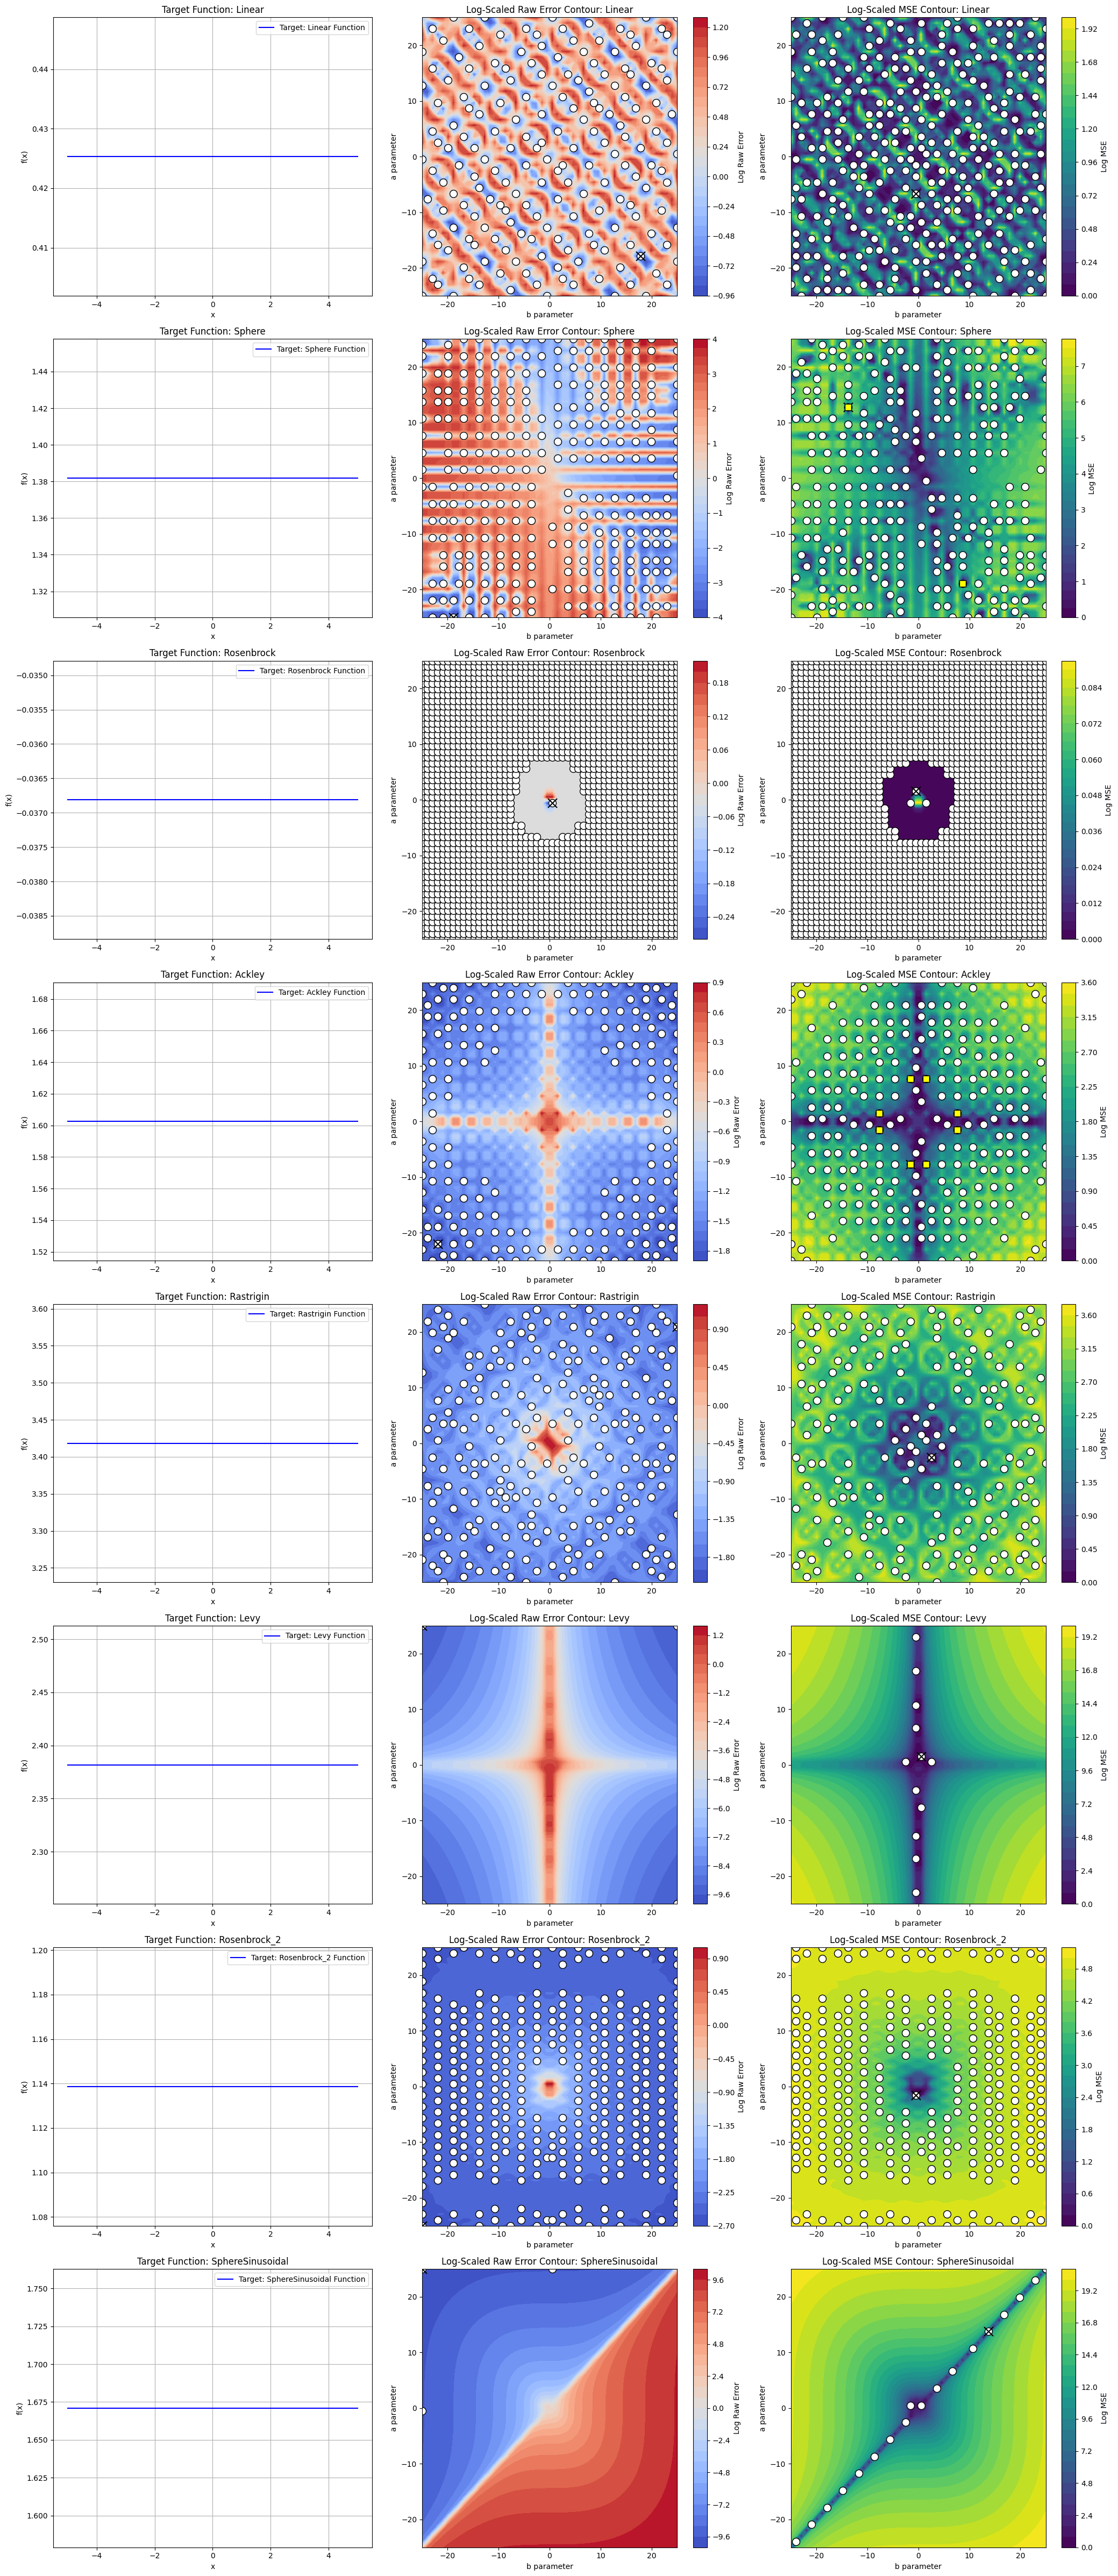

In [8]:
"""
models = {
    "Linear": linear_model_b,
    "Sphere": sphere_model_b,
    "Rosenbrock": rosenbrock_model_b,
    "Ackley": ackley_model_b,
    "Rastrigin": rastrigin_model_b,
    "Levy": levy_model_b,
    "Rastrigin": rastrigin_levy_model,
    "Rosenbrock_2": rosenbrock_ackley_model,
    "SphereSinusoidal": sphere_sinusoidal_model
}
"""

models = {
    "Linear": model_1,
    "Sphere": model_2,
    "Rosenbrock": model_3,
    "Ackley": model_4,
    "Rastrigin": model_5,
    "Levy": model_6,
    "Rastrigin": model_7,
    "Rosenbrock_2": model_8,
    "SphereSinusoidal": model_9
}

# Define the true parameters for each function
"""
true_params = {
    "Linear": (1, 1),
    "Sphere": (1, 0),
    "Rosenbrock": (1, 0),
    "Ackley": (1, 1),
    "Rastrigin": (1, 1),
    "Levy": (1, 0),
    "Rastrigin": (1, 0),
    "Rosenbrock_2": (1, 0),
    "SphereSinusoidal": (1, 0),
}
"""

true_params = {
    "Linear": (1, 1),
    "Sphere": (1, 1),
    "Rosenbrock": (1, 1),
    "Ackley": (1, 1),
    "Rastrigin": (1, 1),
    "Levy": (1, 1),
    "Rastrigin": (1, 1),
    "Rosenbrock_2": (1, 1),
    "SphereSinusoidal": (1, 1),
}

# Define manual thresholds for detecting near-zero points separately for Raw Error and MSE
manual_thresholds = {
    "Raw Error": 0.00001,
    "MSE": 0.00001,
}

# Define the search space for parameters a and b
a_values = np.linspace(-25, 25, 50)  
b_values = np.linspace(-25, 25, 50)

# Generate equally spaced sample points in 1D for function evaluation
num_points = 10  
x_range_1D = np.linspace(-5, 5, num_points)

# Small constant to avoid log(0)
epsilon = 1e-6

# Create plots for each function
fig, axs = plt.subplots(len(models), 3, figsize=(21, 6 * len(models)))

for idx, (name, model) in enumerate(models.items()):
    # Define the target function using the true parameters
    true_a, true_b = true_params[name]
    def target_function(x):
        return model(x, true_a, true_b)

    # Compute true function values
    true_values_1D = np.array([target_function([x]) for x in x_range_1D])

    # Compute raw error and MSE over the (a, b) grid
    error_grid = np.zeros((len(a_values), len(b_values)))
    MSE_grid = np.zeros((len(a_values), len(b_values)))

    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            predicted_values = np.array([model([x], a, b) for x in x_range_1D])
            error_grid[i, j] = np.mean(true_values_1D - predicted_values)  
            MSE_grid[i, j] = np.mean((true_values_1D - predicted_values) ** 2)  

    # Apply log transformation to keep values manageable
    error_grid_log = np.sign(error_grid) * np.log1p(np.abs(error_grid) + epsilon)
    MSE_grid_log = np.log1p(MSE_grid + epsilon)

    # Find local and global minima for raw error and MSE
    def find_local_minima(grid, a_vals, b_vals):
        local_min_mask = grid == scipy.ndimage.minimum_filter(grid, size=3)
        return [(a_vals[i], b_vals[j]) for i, j in np.argwhere(local_min_mask)]

    def find_global_minimum(grid, a_vals, b_vals):
        min_index = np.unravel_index(np.argmin(grid), grid.shape)
        return (a_vals[min_index[0]], b_vals[min_index[1]])

    local_minima = find_local_minima(error_grid_log, a_values, b_values)
    global_minimum = find_global_minimum(error_grid_log, a_values, b_values)

    local_minima_mse = find_local_minima(MSE_grid_log, a_values, b_values)
    global_minimum_mse = find_global_minimum(MSE_grid_log, a_values, b_values)

    # Detect zero-error points
    zero_threshold_raw = manual_thresholds["Raw Error"]
    zero_mask_raw = np.isclose(error_grid_log, 0, atol=zero_threshold_raw)
    zero_a_b_raw = [(a_values[i], b_values[j]) for i, j in np.argwhere(zero_mask_raw)]

    zero_threshold_mse = manual_thresholds["MSE"]
    zero_mask_mse = np.isclose(MSE_grid_log, 0, atol=zero_threshold_mse)
    zero_a_b_mse = [(a_values[i], b_values[j]) for i, j in np.argwhere(zero_mask_mse)]

    # Plot the target function (1D)
    axs[idx, 0].plot(x_range_1D, true_values_1D, color='blue', label=f"Target: {name} Function")
    axs[idx, 0].set_title(f"Target Function: {name}")
    axs[idx, 0].set_xlabel("x")
    axs[idx, 0].set_ylabel("f(x)")
    axs[idx, 0].grid(True)
    axs[idx, 0].legend()

    # Plot the raw error contour with log scaling
    cmap1 = axs[idx, 1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")  

    for a, b in local_minima:
        axs[idx, 1].scatter(b, a, color="white", marker="o", edgecolors="black", s=100)

    axs[idx, 1].scatter(global_minimum[1], global_minimum[0], color="black", marker="x", s=150, label="Global Minimum")

    for a, b in zero_a_b_raw:
        axs[idx, 1].scatter(b, a, color="yellow", marker="s", edgecolors="black", s=80, label="Zero Error (Raw)")

    axs[idx, 1].set_title(f"Log-Scaled Raw Error Contour: {name}")
    axs[idx, 1].set_xlabel("b parameter")
    axs[idx, 1].set_ylabel("a parameter")
    fig.colorbar(cmap1, ax=axs[idx, 1], label="Log Raw Error")

    # Plot the MSE contour plot with log scaling
    cmap2 = axs[idx, 2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")  

    for a, b in local_minima_mse:
        axs[idx, 2].scatter(b, a, color="white", marker="o", edgecolors="black", s=100)

    axs[idx, 2].scatter(global_minimum_mse[1], global_minimum_mse[0], color="black", marker="x", s=150, label="Global Minimum")

    for a, b in zero_a_b_mse:
        axs[idx, 2].scatter(b, a, color="yellow", marker="s", edgecolors="black", s=80, label="Zero Error (MSE)")

    axs[idx, 2].set_title(f"Log-Scaled MSE Contour: {name}")
    axs[idx, 2].set_xlabel("b parameter")
    axs[idx, 2].set_ylabel("a parameter")
    fig.colorbar(cmap2, ax=axs[idx, 2], label="Log MSE")

plt.tight_layout()
plt.show()


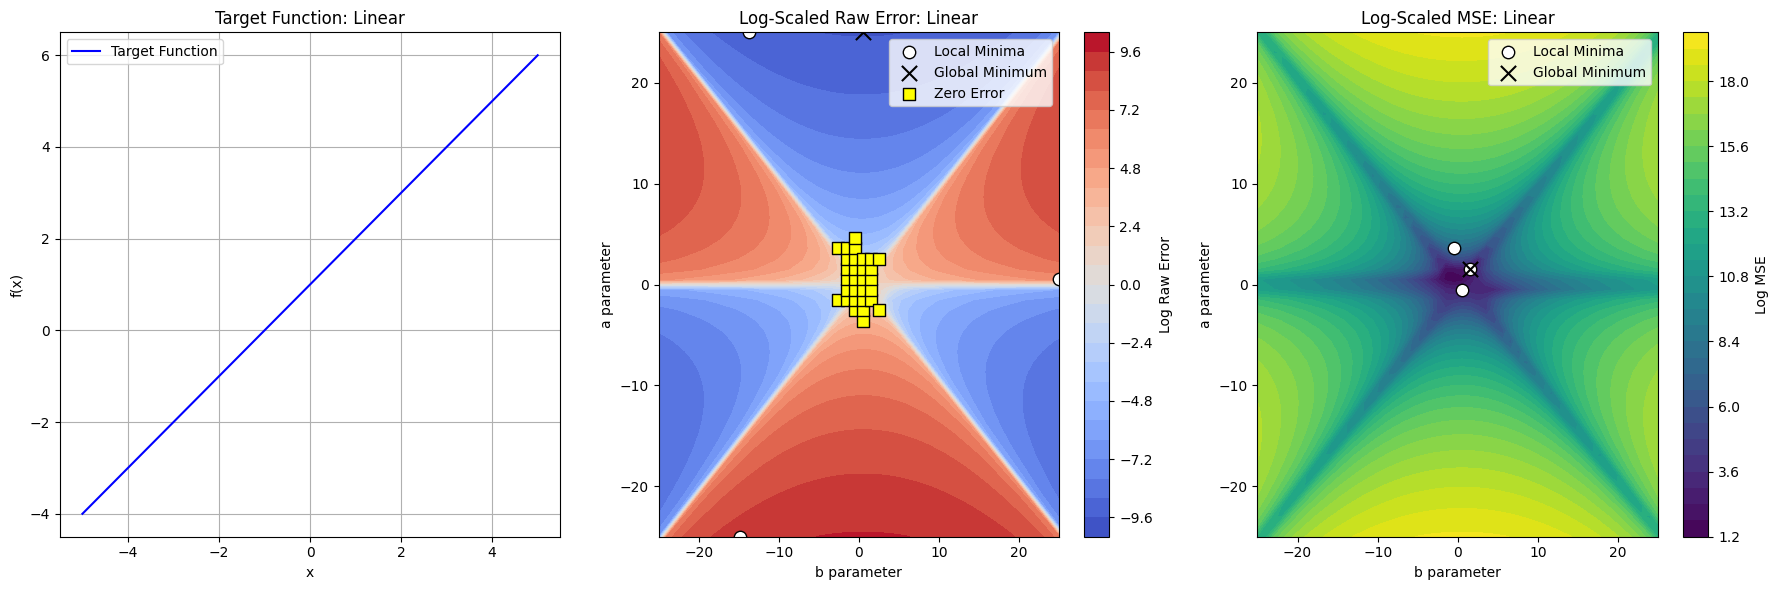

In [9]:
# Re-import necessary libraries due to execution state reset
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

# Redefine the Linear model function
def linear_model_b(x, a, b):
    x = np.array(x)
    return a * np.sum(x) + b * a -b**2*a + a**3 - b

manual_thresholds = {
    "Raw Error": 1,
    "MSE": 1,
}

# Define the search space for parameters a and b
a_values = np.linspace(-25, 25, 50)  
b_values = np.linspace(-25, 25, 50)

# Generate equally spaced sample points in 1D for function evaluation
num_points = 100  
x_range_1D = np.linspace(-5, 5, num_points)

# Small constant to avoid log(0)
epsilon = 1e-6

# Define the true parameters for the Linear function
true_a, true_b = 1, 0

# Define the target function using the true parameters
def target_function(x):
    return linear_model_b(x, true_a, true_b)

# Compute true function values
true_values_1D = np.array([target_function(x) for x in x_range_1D])

# Compute raw error and MSE over the (a, b) grid
error_grid = np.zeros((len(a_values), len(b_values)))
MSE_grid = np.zeros((len(a_values), len(b_values)))

for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        predicted_values = np.array([linear_model_b(x, a, b) for x in x_range_1D])
        error_grid[i, j] = np.mean(true_values_1D - predicted_values)  
        MSE_grid[i, j] = np.mean((true_values_1D - predicted_values) ** 2)  

# Apply log transformation to keep values manageable
error_grid_log = np.sign(error_grid) * np.log1p(np.abs(error_grid) + epsilon)
MSE_grid_log = np.log1p(MSE_grid + epsilon)

# Functions to find local and global minima
def find_local_minima(grid, a_vals, b_vals):
    local_min_mask = grid == scipy.ndimage.minimum_filter(grid, size=3)
    return [(a_vals[i], b_vals[j]) for i, j in np.argwhere(local_min_mask)]

def find_global_minimum(grid, a_vals, b_vals):
    min_index = np.unravel_index(np.argmin(grid), grid.shape)
    return (a_vals[min_index[0]], b_vals[min_index[1]])

# Find local and global minima for raw error and MSE
local_minima = find_local_minima(error_grid_log, a_values, b_values)
global_minimum = find_global_minimum(error_grid_log, a_values, b_values)

local_minima_mse = find_local_minima(MSE_grid_log, a_values, b_values)
global_minimum_mse = find_global_minimum(MSE_grid_log, a_values, b_values)

# Define manual thresholds for detecting near-zero points separately for Raw Error and MSE
manual_thresholds = {
    "Raw Error": 2,
    "MSE": 1,
}

# Detect zero-error points
zero_mask_raw = np.isclose(error_grid_log, 0, atol=manual_thresholds["Raw Error"])
zero_a_b_raw = [(a_values[i], b_values[j]) for i, j in np.argwhere(zero_mask_raw)]

zero_mask_mse = np.isclose(MSE_grid_log, 0, atol=manual_thresholds["MSE"])
zero_a_b_mse = [(a_values[i], b_values[j]) for i, j in np.argwhere(zero_mask_mse)]

# Create plots for the Linear model
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the target function (1D)
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].set_title(f"Target Function: Linear")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Plot the raw error contour with log scaling
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

if local_minima:
    axs[1].scatter(*zip(*local_minima), color="white", marker="o", edgecolors="black", s=80, label="Local Minima")

axs[1].scatter(global_minimum[1], global_minimum[0], color="black", marker="x", s=120, label="Global Minimum")

if zero_a_b_raw:
    axs[1].scatter(*zip(*zero_a_b_raw), color="yellow", marker="s", edgecolors="black", s=80, label="Zero Error")

axs[1].set_title(f"Log-Scaled Raw Error: Linear")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# Plot the MSE contour plot with log scaling
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

if local_minima_mse:
    axs[2].scatter(*zip(*local_minima_mse), color="white", marker="o", edgecolors="black", s=80, label="Local Minima")

axs[2].scatter(global_minimum_mse[1], global_minimum_mse[0], color="black", marker="x", s=120, label="Global Minimum")

if zero_a_b_mse:
    axs[2].scatter(*zip(*zero_a_b_mse), color="yellow", marker="s", edgecolors="black", s=80, label="Zero Error")

axs[2].set_title(f"Log-Scaled MSE: Linear")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


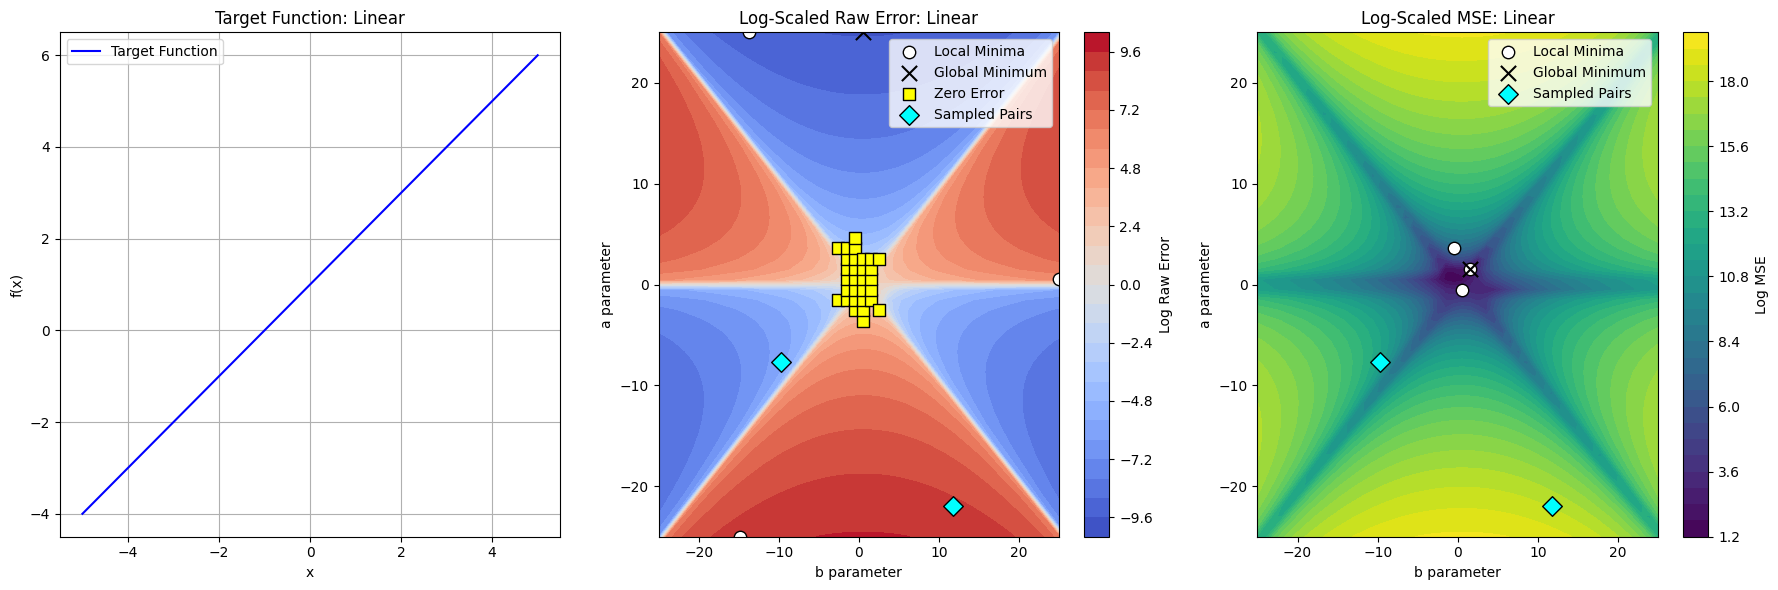

In [10]:
import random

# Number of samples to take from the search space
num_samples = 2

# Randomly sample pairs of (a, b) values for the two models
sampled_pairs = [(random.choice(a_values), random.choice(b_values)) for _ in range(num_samples)]

# Create plots for the Linear model with sampled points marked
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the target function (1D)
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].set_title(f"Target Function: Linear")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Plot the raw error contour with log scaling
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

if local_minima:
    axs[1].scatter(*zip(*local_minima), color="white", marker="o", edgecolors="black", s=80, label="Local Minima")

axs[1].scatter(global_minimum[1], global_minimum[0], color="black", marker="x", s=120, label="Global Minimum")

if zero_a_b_raw:
    axs[1].scatter(*zip(*zero_a_b_raw), color="yellow", marker="s", edgecolors="black", s=80, label="Zero Error")

# Mark sampled pairs on raw error plot
for a, b in sampled_pairs:
    axs[1].scatter(b, a, color="cyan", marker="D", edgecolors="black", s=100, label="Sampled Pairs" if "Sampled Pairs" not in axs[1].get_legend_handles_labels()[1] else "")

axs[1].set_title(f"Log-Scaled Raw Error: Linear")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# Plot the MSE contour plot with log scaling
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

if local_minima_mse:
    axs[2].scatter(*zip(*local_minima_mse), color="white", marker="o", edgecolors="black", s=80, label="Local Minima")

axs[2].scatter(global_minimum_mse[1], global_minimum_mse[0], color="black", marker="x", s=120, label="Global Minimum")

if zero_a_b_mse:
    axs[2].scatter(*zip(*zero_a_b_mse), color="yellow", marker="s", edgecolors="black", s=80, label="Zero Error")

# Mark sampled pairs on MSE plot
for a, b in sampled_pairs:
    axs[2].scatter(b, a, color="cyan", marker="D", edgecolors="black", s=100, label="Sampled Pairs" if "Sampled Pairs" not in axs[2].get_legend_handles_labels()[1] else "")

axs[2].set_title(f"Log-Scaled MSE: Linear")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


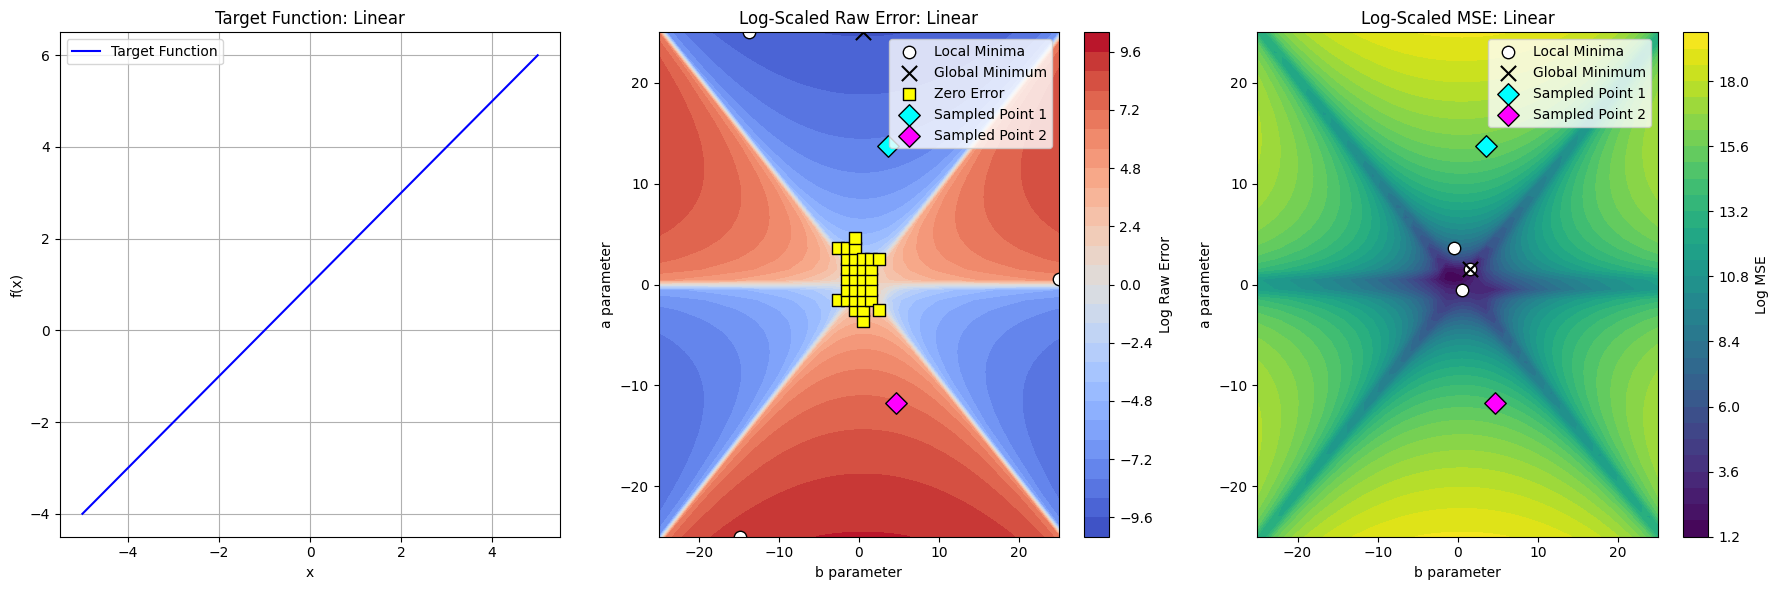

In [11]:
# Function to sample two points ensuring one is positive and the other is negative in raw error
def sample_valid_pairs(error_grid, a_vals, b_vals):
    while True:
        # Randomly sample two pairs of (a, b) values
        sampled_pair_1 = (random.choice(a_vals), random.choice(b_vals))
        sampled_pair_2 = (random.choice(a_vals), random.choice(b_vals))

        # Get their corresponding error values
        idx1 = (np.abs(a_vals - sampled_pair_1[0])).argmin(), (np.abs(b_vals - sampled_pair_1[1])).argmin()
        idx2 = (np.abs(a_vals - sampled_pair_2[0])).argmin(), (np.abs(b_vals - sampled_pair_2[1])).argmin()

        error_1 = error_grid[idx1]
        error_2 = error_grid[idx2]

        # Ensure one error is positive and the other is negative
        if error_1 * error_2 < 0:
            return sampled_pair_1, sampled_pair_2

# Sample two valid points
sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid, a_values, b_values)

# Create plots for the Linear model with the selected sampled points
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the target function (1D)
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].set_title(f"Target Function: Linear")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Plot the raw error contour with log scaling
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

if local_minima:
    axs[1].scatter(*zip(*local_minima), color="white", marker="o", edgecolors="black", s=80, label="Local Minima")

axs[1].scatter(global_minimum[1], global_minimum[0], color="black", marker="x", s=120, label="Global Minimum")

if zero_a_b_raw:
    axs[1].scatter(*zip(*zero_a_b_raw), color="yellow", marker="s", edgecolors="black", s=80, label="Zero Error")

# Mark the two sampled points
axs[1].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[1].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

axs[1].set_title(f"Log-Scaled Raw Error: Linear")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# Plot the MSE contour plot with log scaling
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

if local_minima_mse:
    axs[2].scatter(*zip(*local_minima_mse), color="white", marker="o", edgecolors="black", s=80, label="Local Minima")

axs[2].scatter(global_minimum_mse[1], global_minimum_mse[0], color="black", marker="x", s=120, label="Global Minimum")

if zero_a_b_mse:
    axs[2].scatter(*zip(*zero_a_b_mse), color="yellow", marker="s", edgecolors="black", s=80, label="Zero Error")

# Mark the two sampled points on the MSE plot
axs[2].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[2].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

axs[2].set_title(f"Log-Scaled MSE: Linear")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


In [12]:
# Implementing the Bisection Method to find the zero crossing point

def bisection_method(error_grid, a_vals, b_vals, tol=1e-3, max_iter=50):
    """
    Uses the Bisection Method to find the point where the raw error is closest to zero.
    :param error_grid: 2D array containing error values for (a, b) grid
    :param a_vals: 1D array of 'a' parameter values
    :param b_vals: 1D array of 'b' parameter values
    :param tol: Tolerance for stopping condition
    :param max_iter: Maximum number of iterations
    :return: (a_zero, b_zero) - estimated zero crossing point
    """
    
    # Get the initial sampled points
    (a_low, b_low), (a_high, b_high) = sampled_pair_1, sampled_pair_2

    for _ in range(max_iter):
        # Compute midpoint
        a_mid = (a_low + a_high) / 2
        b_mid = (b_low + b_high) / 2

        # Get error at midpoint
        idx_mid = (np.abs(a_vals - a_mid)).argmin(), (np.abs(b_vals - b_mid)).argmin()
        error_mid = error_grid[idx_mid]

        # If error is sufficiently close to zero, stop
        if abs(error_mid) < tol:
            return a_mid, b_mid

        # Update bounds based on sign of error
        idx_low = (np.abs(a_vals - a_low)).argmin(), (np.abs(b_vals - b_low)).argmin()
        error_low = error_grid[idx_low]

        if error_mid * error_low < 0:  # Zero crossing lies between (a_low, b_low) and (a_mid, b_mid)
            a_high, b_high = a_mid, b_mid
        else:  # Zero crossing lies between (a_mid, b_mid) and (a_high, b_high)
            a_low, b_low = a_mid, b_mid

    return a_mid, b_mid  # Return the best approximation

# Run the Bisection Method to find the zero crossing
a_zero, b_zero = bisection_method(error_grid, a_values, b_values)

# Create plots with the estimated zero crossing point
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the target function (1D)
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].set_title(f"Target Function: Linear")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Plot the raw error contour with log scaling
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

if local_minima:
    axs[1].scatter(*zip(*local_minima), color="white", marker="o", edgecolors="black", s=80, label="Local Minima")

axs[1].scatter(global_minimum[1], global_minimum[0], color="black", marker="x", s=120, label="Global Minimum")

if zero_a_b_raw:
    axs[1].scatter(*zip(*zero_a_b_raw), color="yellow", marker="s", edgecolors="black", s=80, label="Zero Error")

# Mark the sampled points
axs[1].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[1].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

# Mark the estimated zero crossing point
axs[1].scatter(b_zero, a_zero, color="red", marker="*", edgecolors="black", s=140, label="Estimated Zero")

axs[1].set_title(f"Log-Scaled Raw Error: Linear")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# Plot the MSE contour plot with log scaling
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

if local_minima_mse:
    axs[2].scatter(*zip(*local_minima_mse), color="white", marker="o", edgecolors="black", s=80, label="Local Minima")

axs[2].scatter(global_minimum_mse[1], global_minimum_mse[0], color="black", marker="x", s=120, label="Global Minimum")

if zero_a_b_mse:
    axs[2].scatter(*zip(*zero_a_b_mse), color="yellow", marker="s", edgecolors="black", s=80, label="Zero Error")

# Mark the sampled points on the MSE plot
axs[2].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[2].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

# Mark the estimated zero crossing point
axs[2].scatter(b_zero, a_zero, color="red", marker="*", edgecolors="black", s=140, label="Estimated Zero")

axs[2].set_title(f"Log-Scaled MSE: Linear")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


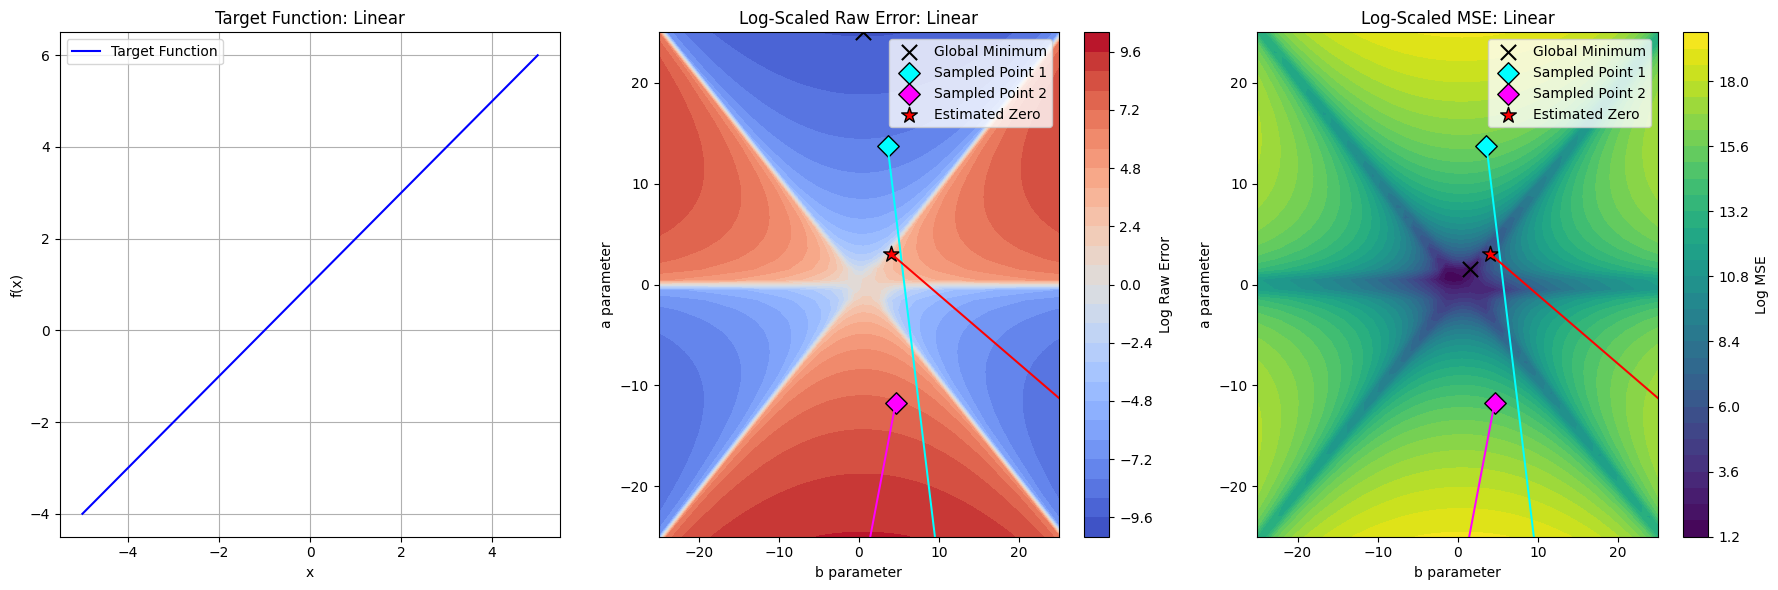

In [13]:
# Compute the gradient of the error function at sampled points and the estimated zero-crossing point
def compute_gradient(error_grid, a_vals, b_vals, point):
    """
    Computes the gradient of the error function at a given point using finite differences.
    """
    a, b = point
    idx_a = (np.abs(a_vals - a)).argmin()
    idx_b = (np.abs(b_vals - b)).argmin()

    # Finite differences (central difference when possible, forward/backward otherwise)
    if 0 < idx_a < len(a_vals) - 1:
        grad_a = (error_grid[idx_a + 1, idx_b] - error_grid[idx_a - 1, idx_b]) / (a_vals[idx_a + 1] - a_vals[idx_a - 1])
    else:
        grad_a = (error_grid[idx_a + 1, idx_b] - error_grid[idx_a, idx_b]) / (a_vals[idx_a + 1] - a_vals[idx_a]) if idx_a < len(a_vals) - 1 else \
                 (error_grid[idx_a, idx_b] - error_grid[idx_a - 1, idx_b]) / (a_vals[idx_a] - a_vals[idx_a - 1])

    if 0 < idx_b < len(b_vals) - 1:
        grad_b = (error_grid[idx_a, idx_b + 1] - error_grid[idx_a, idx_b - 1]) / (b_vals[idx_b + 1] - b_vals[idx_b - 1])
    else:
        grad_b = (error_grid[idx_a, idx_b + 1] - error_grid[idx_a, idx_b]) / (b_vals[idx_b + 1] - b_vals[idx_b]) if idx_b < len(b_vals) - 1 else \
                 (error_grid[idx_a, idx_b] - error_grid[idx_a, idx_b - 1]) / (b_vals[idx_b] - b_vals[idx_b - 1])

    return np.array([grad_a, grad_b])

# Compute gradients at the sampled points and the zero point
grad_sample_1 = compute_gradient(error_grid, a_values, b_values, sampled_pair_1)
grad_sample_2 = compute_gradient(error_grid, a_values, b_values, sampled_pair_2)
grad_zero = compute_gradient(error_grid, a_values, b_values, (a_zero, b_zero))

# Scale the gradient vectors for visualization
scaling_factor = 50  # Adjust to keep arrows visible but not too large
grad_sample_1_scaled = grad_sample_1 * scaling_factor
grad_sample_2_scaled = grad_sample_2 * scaling_factor
grad_zero_scaled = grad_zero * scaling_factor

# Create plots with gradient visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the target function (1D)
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].set_title(f"Target Function: Linear")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Plot the raw error contour with log scaling
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

axs[1].scatter(global_minimum[1], global_minimum[0], color="black", marker="x", s=120, label="Global Minimum")

# Mark the sampled points
axs[1].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[1].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

# Mark the estimated zero crossing point
axs[1].scatter(b_zero, a_zero, color="red", marker="*", edgecolors="black", s=140, label="Estimated Zero")

# Draw gradient arrows
axs[1].quiver(sampled_pair_1[1], sampled_pair_1[0], grad_sample_1_scaled[1], grad_sample_1_scaled[0], color="cyan", angles="xy", scale_units="xy", scale=1, width=0.005)
axs[1].quiver(sampled_pair_2[1], sampled_pair_2[0], grad_sample_2_scaled[1], grad_sample_2_scaled[0], color="magenta", angles="xy", scale_units="xy", scale=1, width=0.005)
axs[1].quiver(b_zero, a_zero, grad_zero_scaled[1], grad_zero_scaled[0], color="red", angles="xy", scale_units="xy", scale=1, width=0.005)

axs[1].set_title(f"Log-Scaled Raw Error: Linear")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# Plot the MSE contour plot with log scaling
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

axs[2].scatter(global_minimum_mse[1], global_minimum_mse[0], color="black", marker="x", s=120, label="Global Minimum")

# Mark the sampled points on the MSE plot
axs[2].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[2].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

# Mark the estimated zero crossing point
axs[2].scatter(b_zero, a_zero, color="red", marker="*", edgecolors="black", s=140, label="Estimated Zero")

# Draw gradient arrows
axs[2].quiver(sampled_pair_1[1], sampled_pair_1[0], grad_sample_1_scaled[1], grad_sample_1_scaled[0], color="cyan", angles="xy", scale_units="xy", scale=1, width=0.005)
axs[2].quiver(sampled_pair_2[1], sampled_pair_2[0], grad_sample_2_scaled[1], grad_sample_2_scaled[0], color="magenta", angles="xy", scale_units="xy", scale=1, width=0.005)
axs[2].quiver(b_zero, a_zero, grad_zero_scaled[1], grad_zero_scaled[0], color="red", angles="xy", scale_units="xy", scale=1, width=0.005)

axs[2].set_title(f"Log-Scaled MSE: Linear")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


In [14]:
# Compute the gradient of the MSE function at sampled points and the estimated zero-crossing point
def compute_gradient_mse(mse_grid, a_vals, b_vals, point):
    """
    Computes the gradient of the MSE function at a given point using finite differences.
    """
    a, b = point
    idx_a = (np.abs(a_vals - a)).argmin()
    idx_b = (np.abs(b_vals - b)).argmin()

    # Finite differences (central difference when possible, forward/backward otherwise)
    if 0 < idx_a < len(a_vals) - 1:
        grad_a = (mse_grid[idx_a + 1, idx_b] - mse_grid[idx_a - 1, idx_b]) / (a_vals[idx_a + 1] - a_vals[idx_a - 1])
    else:
        grad_a = (mse_grid[idx_a + 1, idx_b] - mse_grid[idx_a, idx_b]) / (a_vals[idx_a + 1] - a_vals[idx_a]) if idx_a < len(a_vals) - 1 else \
                 (mse_grid[idx_a, idx_b] - mse_grid[idx_a - 1, idx_b]) / (a_vals[idx_a] - a_vals[idx_a - 1])

    if 0 < idx_b < len(b_vals) - 1:
        grad_b = (mse_grid[idx_a, idx_b + 1] - mse_grid[idx_a, idx_b - 1]) / (b_vals[idx_b + 1] - b_vals[idx_b - 1])
    else:
        grad_b = (mse_grid[idx_a, idx_b + 1] - mse_grid[idx_a, idx_b]) / (b_vals[idx_b + 1] - b_vals[idx_b]) if idx_b < len(b_vals) - 1 else \
                 (mse_grid[idx_a, idx_b] - mse_grid[idx_a, idx_b - 1]) / (b_vals[idx_b] - b_vals[idx_b - 1])

    return np.array([grad_a, grad_b])

# Compute gradients at the sampled points and the zero point for MSE
grad_sample_1_mse = compute_gradient_mse(MSE_grid_log, a_values, b_values, sampled_pair_1)
grad_sample_2_mse = compute_gradient_mse(MSE_grid_log, a_values, b_values, sampled_pair_2)
grad_zero_mse = compute_gradient_mse(MSE_grid_log, a_values, b_values, (a_zero, b_zero))

# Adjusted scaling factor for better visualization
scaling_factor = 10

grad_sample_1_scaled = grad_sample_1 * scaling_factor
grad_sample_2_scaled = grad_sample_2 * scaling_factor
grad_zero_scaled = grad_zero * scaling_factor

grad_sample_1_mse_scaled = grad_sample_1_mse * scaling_factor
grad_sample_2_mse_scaled = grad_sample_2_mse * scaling_factor
grad_zero_mse_scaled = grad_zero_mse * scaling_factor

# Create plots with adjusted gradient visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the target function (1D)
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].set_title(f"Target Function: Linear")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Plot the raw error contour with log scaling
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

axs[1].scatter(global_minimum[1], global_minimum[0], color="black", marker="x", s=120, label="Global Minimum")

# Mark the sampled points
axs[1].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[1].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

# Mark the estimated zero crossing point
axs[1].scatter(b_zero, a_zero, color="red", marker="*", edgecolors="black", s=140, label="Estimated Zero")

# Draw gradient arrows for raw error
axs[1].quiver(sampled_pair_1[1], sampled_pair_1[0], grad_sample_1_scaled[1], grad_sample_1_scaled[0], color="cyan", angles="xy", scale_units="xy", scale=1, width=0.005)
axs[1].quiver(sampled_pair_2[1], sampled_pair_2[0], grad_sample_2_scaled[1], grad_sample_2_scaled[0], color="magenta", angles="xy", scale_units="xy", scale=1, width=0.005)
axs[1].quiver(b_zero, a_zero, grad_zero_scaled[1], grad_zero_scaled[0], color="red", angles="xy", scale_units="xy", scale=1, width=0.005)

axs[1].set_title(f"Log-Scaled Raw Error: Linear")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# Plot the MSE contour plot with log scaling
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

axs[2].scatter(global_minimum_mse[1], global_minimum_mse[0], color="black", marker="x", s=120, label="Global Minimum")

# Mark the sampled points on the MSE plot
axs[2].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[2].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

# Mark the estimated zero crossing point
axs[2].scatter(b_zero, a_zero, color="red", marker="*", edgecolors="black", s=140, label="Estimated Zero")

# Draw gradient arrows for MSE
axs[2].quiver(sampled_pair_1[1], sampled_pair_1[0], grad_sample_1_mse_scaled[1], grad_sample_1_mse_scaled[0], color="cyan", angles="xy", scale_units="xy", scale=1, width=0.005)
axs[2].quiver(sampled_pair_2[1], sampled_pair_2[0], grad_sample_2_mse_scaled[1], grad_sample_2_mse_scaled[0], color="magenta", angles="xy", scale_units="xy", scale=1, width=0.005)
axs[2].quiver(b_zero, a_zero, grad_zero_mse_scaled[1], grad_zero_mse_scaled[0], color="red", angles="xy", scale_units="xy", scale=1, width=0.005)

axs[2].set_title(f"Log-Scaled MSE: Linear")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


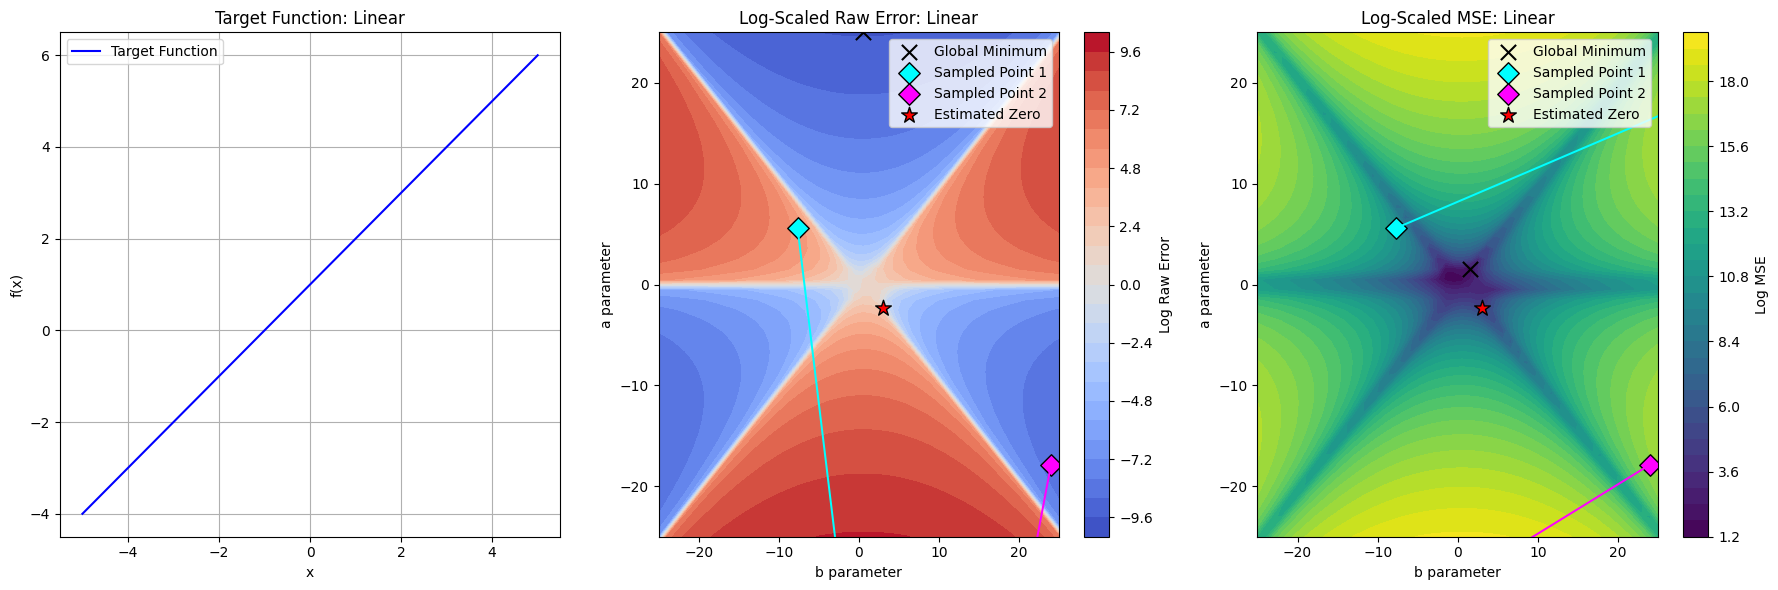

In [15]:
sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid, a_values, b_values)
a_zero, b_zero = bisection_method(error_grid, a_values, b_values)

# Compute gradients at the sampled points and the zero point for MSE
grad_sample_1_mse = compute_gradient_mse(MSE_grid_log, a_values, b_values, sampled_pair_1)
grad_sample_2_mse = compute_gradient_mse(MSE_grid_log, a_values, b_values, sampled_pair_2)

# Scaling factor for visualization
scaling_factor = 10

# Scale gradients for Raw Error
grad_sample_1_scaled = grad_sample_1 * scaling_factor
grad_sample_2_scaled = grad_sample_2 * scaling_factor

# Scale gradients for MSE
grad_sample_1_mse_scaled = - grad_sample_1_mse * scaling_factor**10
grad_sample_2_mse_scaled = - grad_sample_2_mse * scaling_factor**10

# Create plots with adjusted gradient visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the target function (1D)
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].set_title(f"Target Function: Linear")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Plot the raw error contour with log scaling
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

axs[1].scatter(global_minimum[1], global_minimum[0], color="black", marker="x", s=120, label="Global Minimum")

# Mark the sampled points
axs[1].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[1].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

# Mark the estimated zero crossing point
axs[1].scatter(b_zero, a_zero, color="red", marker="*", edgecolors="black", s=140, label="Estimated Zero")

# Draw gradient arrows for raw error
axs[1].quiver(sampled_pair_1[1], sampled_pair_1[0], grad_sample_1_scaled[1], grad_sample_1_scaled[0], color="cyan", angles="xy", scale_units="xy", scale=1, width=0.005)
axs[1].quiver(sampled_pair_2[1], sampled_pair_2[0], grad_sample_2_scaled[1], grad_sample_2_scaled[0], color="magenta", angles="xy", scale_units="xy", scale=1, width=0.005)

axs[1].set_title(f"Log-Scaled Raw Error: Linear")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# Plot the MSE contour plot with log scaling
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

axs[2].scatter(global_minimum_mse[1], global_minimum_mse[0], color="black", marker="x", s=120, label="Global Minimum")

# Mark the sampled points on the MSE plot
axs[2].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
axs[2].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

# Mark the estimated zero crossing point
axs[2].scatter(b_zero, a_zero, color="red", marker="*", edgecolors="black", s=140, label="Estimated Zero")

# Draw gradient arrows for MSE
axs[2].quiver(sampled_pair_1[1], sampled_pair_1[0], grad_sample_1_mse_scaled[1], grad_sample_1_mse_scaled[0], color="cyan", angles="xy", scale_units="xy", scale=1, width=0.005)
axs[2].quiver(sampled_pair_2[1], sampled_pair_2[0], grad_sample_2_mse_scaled[1], grad_sample_2_mse_scaled[0], color="magenta", angles="xy", scale_units="xy", scale=1, width=0.005)

axs[2].set_title(f"Log-Scaled MSE: Linear")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


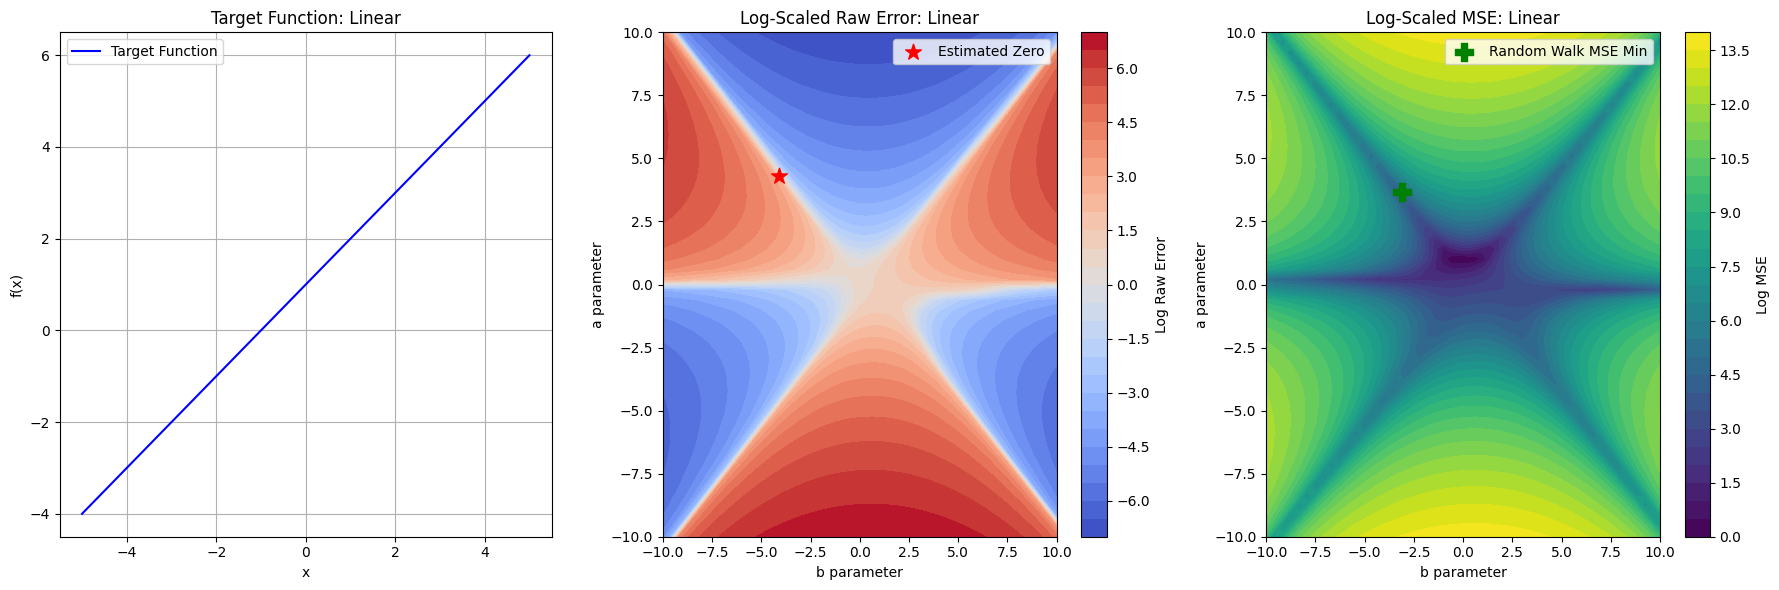

In [16]:
# Re-import necessary libraries since execution state was reset
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.ndimage

# Re-define the linear model function
#def linear_model(x, a, b):
#    x = np.array(x)
#    return a * np.sum(x) + b

# Define the true parameters for the target function
true_a, true_b = 1, 0

# Generate equally spaced sample points in 1D for function evaluation
num_points = 100  
x_range_1D = np.linspace(-5, 5, num_points)

# Compute true function values using the target function
true_values_1D = np.array([linear_model_b([x], true_a, true_b) for x in x_range_1D])

# Define the search space for parameters a and b
a_values = np.linspace(-10, 10, 50)  
b_values = np.linspace(-10, 10, 50)

# Compute raw error and MSE over the (a, b) grid
error_grid = np.zeros((len(a_values), len(b_values)))
MSE_grid = np.zeros((len(a_values), len(b_values)))

for i, a in enumerate(a_values):
    for j, b in enumerate(b_values):
        predicted_values = np.array([linear_model_b([x], a, b) for x in x_range_1D])
        error_grid[i, j] = np.mean(true_values_1D - predicted_values)  
        MSE_grid[i, j] = np.mean((true_values_1D - predicted_values) ** 2)  

# Apply log transformation to keep values manageable
epsilon = 1e-6
error_grid_log = np.sign(error_grid) * np.log1p(np.abs(error_grid) + epsilon)
MSE_grid_log = np.log1p(MSE_grid + epsilon)

# Function to sample two points ensuring one is positive and the other is negative in raw error
def sample_valid_pairs(error_grid, a_vals, b_vals):
    while True:
        sampled_pair_1 = (random.choice(a_vals), random.choice(b_vals))
        sampled_pair_2 = (random.choice(a_vals), random.choice(b_vals))

        idx1 = (np.abs(a_vals - sampled_pair_1[0])).argmin(), (np.abs(b_vals - sampled_pair_1[1])).argmin()
        idx2 = (np.abs(a_vals - sampled_pair_2[0])).argmin(), (np.abs(b_vals - sampled_pair_2[1])).argmin()

        error_1 = error_grid[idx1]
        error_2 = error_grid[idx2]

        if error_1 * error_2 < 0:
            return sampled_pair_1, sampled_pair_2

# Function to find the zero crossing using bisection
def bisection_method(error_grid, a_vals, b_vals, tol=1e-3, max_iter=100):
    a_low, b_low, a_high, b_high = *sampled_pair_1, *sampled_pair_2

    for _ in range(max_iter):
        a_mid = (a_low + a_high) / 2
        b_mid = (b_low + b_high) / 2

        idx_mid = (np.abs(a_vals - a_mid)).argmin(), (np.abs(b_vals - b_mid)).argmin()
        error_mid = error_grid[idx_mid]

        if abs(error_mid) < tol:
            return a_mid, b_mid

        idx_low = (np.abs(a_vals - a_low)).argmin(), (np.abs(b_vals - b_low)).argmin()
        error_low = error_grid[idx_low]

        if error_low * error_mid < 0:
            a_high, b_high = a_mid, b_mid
        else:
            a_low, b_low = a_mid, b_mid

    return a_mid, b_mid

# Function to compute gradients using finite differences
def compute_gradient(grid, a_vals, b_vals, point):
    a, b = point
    idx_a = (np.abs(a_vals - a)).argmin()
    idx_b = (np.abs(b_vals - b)).argmin()

    if 0 < idx_a < len(a_vals) - 1:
        grad_a = (grid[idx_a + 1, idx_b] - grid[idx_a - 1, idx_b]) / (a_vals[idx_a + 1] - a_vals[idx_a - 1])
    else:
        grad_a = 0

    if 0 < idx_b < len(b_vals) - 1:
        grad_b = (grid[idx_a, idx_b + 1] - grid[idx_a, idx_b - 1]) / (b_vals[idx_b + 1] - b_vals[idx_b - 1])
    else:
        grad_b = 0

    return np.array([grad_a, grad_b])

# Random walk to find the minimum MSE from the estimated zero-error region
def random_walk_mse(a_start, b_start, mse_grid, a_vals, b_vals, step_size=0.5, max_iter=100):
    a_current, b_current = a_start, b_start

    for _ in range(max_iter):
        idx_a = (np.abs(a_vals - a_current)).argmin()
        idx_b = (np.abs(b_vals - b_current)).argmin()

        mse_current = mse_grid[idx_a, idx_b]

        step_a = random.uniform(-step_size, step_size)
        step_b = random.uniform(-step_size, step_size)

        a_new, b_new = a_current + step_a, b_current + step_b
        a_new = np.clip(a_new, a_vals[0], a_vals[-1])
        b_new = np.clip(b_new, b_vals[0], b_vals[-1])

        idx_a_new = (np.abs(a_vals - a_new)).argmin()
        idx_b_new = (np.abs(b_vals - b_new)).argmin()
        mse_new = mse_grid[idx_a_new, idx_b_new]

        if mse_new < mse_current:
            a_current, b_current = a_new, b_new

    return a_current, b_current

# Run calculations
sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid, a_values, b_values)
a_zero, b_zero = bisection_method(error_grid, a_values, b_values)
a_mse_min, b_mse_min = random_walk_mse(a_zero, b_zero, MSE_grid, a_values, b_values)

# Create plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Target function plot
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].set_title(f"Target Function: Linear")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Raw error contour plot
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")
axs[1].scatter(b_zero, a_zero, color="red", marker="*", s=140, label="Estimated Zero")
axs[1].set_title(f"Log-Scaled Raw Error: Linear")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# MSE contour plot
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")
axs[2].scatter(b_mse_min, a_mse_min, color="green", marker="P", s=160, label="Random Walk MSE Min")
axs[2].set_title(f"Log-Scaled MSE: Linear")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


In [17]:
# Modify random walk function to store and visualize the path
def random_walk_mse_with_path(a_start, b_start, mse_grid, a_vals, b_vals, step_size=0.5, max_iter=100):
    """
    Performs a random walk in the zero-error region to find a lower MSE value and records the path.
    """
    a_current, b_current = a_start, b_start
    path = [(a_current, b_current)]  # Store path

    for _ in range(max_iter):
        idx_a = (np.abs(a_vals - a_current)).argmin()
        idx_b = (np.abs(b_vals - b_current)).argmin()
        mse_current = mse_grid[idx_a, idx_b]

        step_a = random.uniform(-step_size, step_size)
        step_b = random.uniform(-step_size, step_size)

        a_new, b_new = a_current + step_a, b_current + step_b
        a_new = np.clip(a_new, a_vals[0], a_vals[-1])
        b_new = np.clip(b_new, b_vals[0], b_vals[-1])

        idx_a_new = (np.abs(a_vals - a_new)).argmin()
        idx_b_new = (np.abs(b_vals - b_new)).argmin()
        mse_new = mse_grid[idx_a_new, idx_b_new]

        if mse_new < mse_current:
            a_current, b_current = a_new, b_new
            path.append((a_current, b_current))  # Store path

    return a_current, b_current, path

# Run random walk with path tracking
a_mse_min, b_mse_min, mse_path = random_walk_mse_with_path(a_zero, b_zero, MSE_grid, a_values, b_values)

# Create plots with path visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Target function plot
axs[0].plot(x_range_1D, true_values_1D, color='blue', label="Target Function")
axs[0].set_title(f"Target Function: Linear")
axs[0].set_xlabel("x")
axs[0].set_ylabel("f(x)")
axs[0].grid(True)
axs[0].legend()

# Raw error contour plot
cmap1 = axs[1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")
axs[1].scatter(b_zero, a_zero, color="red", marker="*", s=140, label="Estimated Zero")
axs[1].set_title(f"Log-Scaled Raw Error: Linear")
axs[1].set_xlabel("b parameter")
axs[1].set_ylabel("a parameter")
fig.colorbar(cmap1, ax=axs[1], label="Log Raw Error")
axs[1].legend(loc="upper right")

# MSE contour plot with random walk path
cmap2 = axs[2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

# Mark the path of the random walk
mse_path_array = np.array(mse_path)
axs[2].plot(mse_path_array[:, 1], mse_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="Random Walk Path")

# Mark start and end points
axs[2].scatter(b_zero, a_zero, color="red", marker="*", s=140, label="Estimated Zero")
axs[2].scatter(b_mse_min, a_mse_min, color="green", marker="P", s=160, label="Random Walk MSE Min")

axs[2].set_title(f"Log-Scaled MSE: Linear")
axs[2].set_xlabel("b parameter")
axs[2].set_ylabel("a parameter")
fig.colorbar(cmap2, ax=axs[2], label="Log MSE")
axs[2].legend(loc="upper right")

plt.tight_layout()
plt.show()


In [18]:
""""
models = {
    "Linear": linear_model_b,
    "Sphere": sphere_model_b,
    "Rosenbrock": rosenbrock_model_b,
    "Ackley": ackley_model_b,
    "Rastrigin": rastrigin_model_b,
    "Levy": levy_model_b,
    "Rastrigin": rastrigin_levy_model,
    "Rosenbrock_2": rosenbrock_ackley_model,
    "SphereSinusoidal": sphere_sinusoidal_model
}
"""

models = {
    "Linear": model_1,
    "Sphere": model_2,
    "Rosenbrock": model_3,
    "Ackley": model_4,
    "Rastrigin": model_5,
    "Levy": model_6,
    "Rastrigin": model_7,
    "Rosenbrock_2": model_8,
    "SphereSinusoidal": model_9
}

""""
# Define the true parameters for each function
true_params = {
    "Linear": (1, 1),
    "Sphere": (1, 0),
    "Rosenbrock": (1, 0),
    "Ackley": (1, 1),
    "Rastrigin": (1, 1),
    "Levy": (1, 0),
    "Rastrigin": (1, 0),
    "Rosenbrock_2": (1, 0),
    "SphereSinusoidal": (1, 0),
}
"""

# Define manual thresholds for detecting near-zero points separately for Raw Error and MSE
manual_thresholds = {
    "Raw Error": 1,
    "MSE": 1,
}

# Define the search space for parameters a and b
a_values = np.linspace(-25, 25, 100)  
b_values = np.linspace(-25, 25, 100)

# Generate equally spaced sample points in 1D for function evaluation
num_points = 100  
x_range_1D = np.linspace(-5, 5, num_points)

# Small constant to avoid log(0)
epsilon = 1e-6

# Function to sample two points ensuring one is positive and the other is negative in raw error
def sample_valid_pairs(error_grid, a_vals, b_vals):
    while True:
        sampled_pair_1 = (random.choice(a_vals), random.choice(b_vals))
        sampled_pair_2 = (random.choice(a_vals), random.choice(b_vals))

        idx1 = (np.abs(a_vals - sampled_pair_1[0])).argmin(), (np.abs(b_vals - sampled_pair_1[1])).argmin()
        idx2 = (np.abs(a_vals - sampled_pair_2[0])).argmin(), (np.abs(b_vals - sampled_pair_2[1])).argmin()

        error_1 = error_grid[idx1]
        error_2 = error_grid[idx2]

        if error_1 * error_2 < 0:
            return sampled_pair_1, sampled_pair_2

# Function to find the zero crossing using bisection
def bisection_method(error_grid, a_vals, b_vals, tol=1e-3, max_iter=100):
    a_low, b_low, a_high, b_high = *sampled_pair_1, *sampled_pair_2

    for _ in range(max_iter):
        a_mid = (a_low + a_high) / 2
        b_mid = (b_low + b_high) / 2

        idx_mid = (np.abs(a_vals - a_mid)).argmin(), (np.abs(b_vals - b_mid)).argmin()
        error_mid = error_grid[idx_mid]

        if abs(error_mid) < tol:
            return a_mid, b_mid

        idx_low = (np.abs(a_vals - a_low)).argmin(), (np.abs(b_vals - b_low)).argmin()
        error_low = error_grid[idx_low]

        if error_low * error_mid < 0:
            a_high, b_high = a_mid, b_mid
        else:
            a_low, b_low = a_mid, b_mid

    return a_mid, b_mid

# Random walk to find the minimum MSE from the estimated zero-error region
def random_walk_mse_with_path(a_start, b_start, mse_grid, a_vals, b_vals, step_size=1.5, max_iter=10000):
    a_current, b_current = a_start, b_start
    path = [(a_current, b_current)]  # Store path

    for _ in range(max_iter):
        idx_a = (np.abs(a_vals - a_current)).argmin()
        idx_b = (np.abs(b_vals - b_current)).argmin()
        mse_current = mse_grid[idx_a, idx_b]

        step_a = random.uniform(-step_size, step_size)
        step_b = random.uniform(-step_size, step_size)

        a_new, b_new = a_current + step_a, b_current + step_b
        a_new = np.clip(a_new, a_vals[0], a_vals[-1])
        b_new = np.clip(b_new, b_vals[0], b_vals[-1])

        idx_a_new = (np.abs(a_vals - a_new)).argmin()
        idx_b_new = (np.abs(b_vals - b_new)).argmin()
        mse_new = mse_grid[idx_a_new, idx_b_new]

        if mse_new < mse_current:
            a_current, b_current = a_new, b_new
            path.append((a_current, b_current))  # Store path

    return a_current, b_current, path

"""
# Run the process for all functions
fig, axs = plt.subplots(len(models), 3, figsize=(21, 6 * len(models)))

for idx, (name, model) in enumerate(models.items()):
    true_a, true_b = true_params[name]

    def target_function(x):
        return model(x, true_a, true_b)

    true_values_1D = np.array([target_function([x]) for x in x_range_1D])

    error_grid = np.zeros((len(a_values), len(b_values)))
    MSE_grid = np.zeros((len(a_values), len(b_values)))

    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            predicted_values = np.array([model([x], a, b) for x in x_range_1D])
            error_grid[i, j] = np.mean(true_values_1D - predicted_values)  
            MSE_grid[i, j] = np.mean((true_values_1D - predicted_values) ** 2)  

    error_grid_log = np.sign(error_grid) * np.log1p(np.abs(error_grid) + epsilon)
    MSE_grid_log = np.log1p(MSE_grid + epsilon)

    sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid, a_values, b_values)
    a_zero, b_zero = bisection_method(error_grid, a_values, b_values)
    a_mse_min, b_mse_min, mse_path = random_walk_mse_with_path(a_zero, b_zero, MSE_grid, a_values, b_values)

    cmap1 = axs[idx, 1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")
    cmap2 = axs[idx, 2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

plt.tight_layout()
plt.show()
"""


'\n# Run the process for all functions\nfig, axs = plt.subplots(len(models), 3, figsize=(21, 6 * len(models)))\n\nfor idx, (name, model) in enumerate(models.items()):\n    true_a, true_b = true_params[name]\n\n    def target_function(x):\n        return model(x, true_a, true_b)\n\n    true_values_1D = np.array([target_function([x]) for x in x_range_1D])\n\n    error_grid = np.zeros((len(a_values), len(b_values)))\n    MSE_grid = np.zeros((len(a_values), len(b_values)))\n\n    for i, a in enumerate(a_values):\n        for j, b in enumerate(b_values):\n            predicted_values = np.array([model([x], a, b) for x in x_range_1D])\n            error_grid[i, j] = np.mean(true_values_1D - predicted_values)  \n            MSE_grid[i, j] = np.mean((true_values_1D - predicted_values) ** 2)  \n\n    error_grid_log = np.sign(error_grid) * np.log1p(np.abs(error_grid) + epsilon)\n    MSE_grid_log = np.log1p(MSE_grid + epsilon)\n\n    sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid,

In [19]:
# Redo the visualization with proper marking and function plotting

fig, axs = plt.subplots(len(models), 3, figsize=(21, 6 * len(models)))

for idx, (name, model) in enumerate(models.items()):
    true_a, true_b = true_params[name]

    def target_function(x):
        return model(x, true_a, true_b)

    # Compute true function values
    true_values_1D = np.array([target_function([x]) for x in x_range_1D])

    # Compute raw error and MSE over the (a, b) grid
    error_grid = np.zeros((len(a_values), len(b_values)))
    MSE_grid = np.zeros((len(a_values), len(b_values)))

    for i, a in enumerate(a_values):
        for j, b in enumerate(b_values):
            predicted_values = np.array([model([x], a, b) for x in x_range_1D])
            error_grid[i, j] = np.mean(true_values_1D - predicted_values)  
            MSE_grid[i, j] = np.mean((true_values_1D - predicted_values) ** 2)  

    # Apply log transformation to keep values manageable
    error_grid_log = np.sign(error_grid) * np.log1p(np.abs(error_grid) + epsilon)
    MSE_grid_log = np.log1p(MSE_grid + epsilon)

    # Sample two points with opposite error signs
    sampled_pair_1, sampled_pair_2 = sample_valid_pairs(error_grid, a_values, b_values)

    # Find the zero crossing using bisection
    a_zero, b_zero = bisection_method(error_grid, a_values, b_values)

    # Perform a random walk in the MSE space starting from the zero-error region
    a_mse_min, b_mse_min, mse_path = random_walk_mse_with_path(a_zero, b_zero, MSE_grid, a_values, b_values)

    # Plot target function
    axs[idx, 0].plot(x_range_1D, true_values_1D, color='blue', label=f"Target: {name}")
    axs[idx, 0].set_title(f"Target Function: {name}")
    axs[idx, 0].set_xlabel("x")
    axs[idx, 0].set_ylabel("f(x)")
    axs[idx, 0].grid(True)
    axs[idx, 0].legend()

    # Plot the raw error contour with log scaling
    cmap1 = axs[idx, 1].contourf(b_values, a_values, error_grid_log, levels=30, cmap="coolwarm")

    # Mark estimated zero crossing point
    axs[idx, 1].scatter(b_zero, a_zero, color="red", marker="*", s=140, label="Estimated Zero")

    # Mark the two sampled points
    axs[idx, 1].scatter(sampled_pair_1[1], sampled_pair_1[0], color="cyan", marker="D", edgecolors="black", s=120, label="Sampled Point 1")
    axs[idx, 1].scatter(sampled_pair_2[1], sampled_pair_2[0], color="magenta", marker="D", edgecolors="black", s=120, label="Sampled Point 2")

    axs[idx, 1].set_title(f"Log-Scaled Raw Error: {name}")
    axs[idx, 1].set_xlabel("b parameter")
    axs[idx, 1].set_ylabel("a parameter")
    fig.colorbar(cmap1, ax=axs[idx, 1], label="Log Raw Error")
    axs[idx, 1].legend(loc="upper right")

    # Plot the MSE contour plot with random walk path
    cmap2 = axs[idx, 2].contourf(b_values, a_values, MSE_grid_log, levels=30, cmap="viridis")

    # Mark the path of the random walk
    mse_path_array = np.array(mse_path)
    axs[idx, 2].plot(mse_path_array[:, 1], mse_path_array[:, 0], color="orange", linestyle="--", marker="o", markersize=4, label="Random Walk Path")

    # Mark start and end points
    axs[idx, 2].scatter(b_zero, a_zero, color="red", marker="*", s=140, label="Estimated Zero")
    axs[idx, 2].scatter(b_mse_min, a_mse_min, color="green", marker="P", s=160, label="Random Walk MSE Min")

    axs[idx, 2].set_title(f"Log-Scaled MSE: {name}")
    axs[idx, 2].set_xlabel("b parameter")
    axs[idx, 2].set_ylabel("a parameter")
    fig.colorbar(cmap2, ax=axs[idx, 2], label="Log MSE")
    axs[idx, 2].legend(loc="upper right")

plt.tight_layout()
plt.show()


In [20]:
#--------------------------------
# I now need to create crazy models that are crazy non linear conbination that lead to non convexity, instead of using this well behaved functions. Perhaps generate functions randomly
#--------------------------------

In [21]:
#1) Is it possible to classify regions? Like there is 4 way montain were I should actually go to where the gradient is pointing instead of the cut in half